In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [3]:
import sys
sys.path.insert(0, "../")
import utils.utils as utils
import models.fourier_models as fm

In [4]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

data = fetch_california_housing()
X = torch.from_numpy(data.data)
y = torch.from_numpy(data.target)

X_scaled = utils.data_scaler(X, interval=(-torch.pi/2, torch.pi/2))

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

In [5]:
# generate frequencies
max_freq = 2
dim = X_scaled[0].shape[0]

W = utils.freq_generator(max_freq, dim)

In [ ]:
# compute best approximation
ba_coeffs = utils.fourier_best_approx(W, X_train, y_train)

In [ ]:
print("training_loss: ",utils.loss(W, ba_coeffs, X_train, y_train))
print("test loss: ",utils.loss(W, ba_coeffs, X_test, y_test))

In [ ]:
ba_loss = []
ba_test_loss = []
for max_freq in range(1, 10+1):
    W = utils.freq_generator(max_freq, dim)
    ba_coeffs = utils.fourier_best_approx(W, X_train, y_train)
    ba_loss.append(utils.loss(W, ba_coeffs, X_train, y_train).item()**2)
    ba_test_loss.append(utils.loss(W, ba_coeffs, X_test, y_test).item()**2)
    print("max_freq: ", max_freq)
    print("training_loss: ",utils.loss(W, ba_coeffs, X_train, y_train).item()**2)
    print("test loss: ",utils.loss(W, ba_coeffs, X_test, y_test).item()**2)
    print("parameters: ", len(ba_coeffs))

In [ ]:
# -----------------------------------------

In [5]:
def train(dataloader, model, loss_fn, optimizer, printing=False):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred.flatten(), y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            if printing == True:
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                for param_group in optimizer.param_groups:
                    print("lr: ", param_group['lr'])
        return loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred.flatten(), y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [6]:
train_data_list = []
for i in tqdm(range(len(X_train))):
    data_point = (X_train[i], y_train[i])
    train_data_list.append(data_point)

test_data_list = []
for i in tqdm(range(len(X_test))):
    data_point = (X_test[i], y_test[i])
    test_data_list.append(data_point)

100%|██████████| 4128/4128 [00:00<00:00, 262382.36it/s]


In [7]:
train_dataloader = DataLoader(train_data_list, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_data_list, batch_size=100, shuffle=True)

In [8]:
dim = X_scaled[0].shape[0]
W = utils.freq_generator(4, dim)
model = fm.Fourier_model(W)
model.to(device)
loss_fn = nn.MSELoss(reduction='sum') # equiv. to torch.linalg.norm(input-target)**2
optimizer = torch.optim.Adam(model.parameters())
# scheduler = torch.optim.lr_scheduler.LinearLR(optimizer)

In [9]:
NN_loss = []
NN_test_loss = []
for max_freq in range(1, 6+1):
    W = utils.freq_generator(max_freq, dim).to(device)
    model = fm.Fourier_model(W)
    model.to(device)
    loss_fn = nn.MSELoss(reduction='sum') # equiv. to torch.linalg.norm(input-target)**2
    optimizer = torch.optim.Adam(model.parameters(), lr=5*1e-3)

    epochs = 1000
    for t in tqdm(range(epochs)):
        # print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        # test(test_dataloader, model, loss_fn)
        # scheduler.step()
    print("Done!")
    NN_loss.append(train(train_dataloader, model, loss_fn, optimizer, printing=True))
    NN_test_loss.append(test(test_dataloader, model, loss_fn))

100%|██████████| 1000/1000 [00:02<00:00, 438.63it/s]


Done!
loss: 137.819049  [    0/16512]
lr:  0.005
Test Error: 
 Accuracy: 0.0%, Avg loss: 128.829139 



100%|██████████| 1000/1000 [00:03<00:00, 270.85it/s]


Done!
loss: 163.273596  [    0/16512]
lr:  0.005
Test Error: 
 Accuracy: 0.0%, Avg loss: 140.972836 



100%|██████████| 1000/1000 [00:22<00:00, 43.91it/s]


Done!
loss: 142.053045  [    0/16512]
lr:  0.005
Test Error: 
 Accuracy: 0.0%, Avg loss: 128.870520 



100%|██████████| 1000/1000 [03:16<00:00,  5.09it/s]


Done!
loss: 129.072225  [    0/16512]
lr:  0.005
Test Error: 
 Accuracy: 0.0%, Avg loss: 127.111982 



  0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 1.25 GiB (GPU 0; 1.96 GiB total capacity; 115.34 MiB already allocated; 627.94 MiB free; 352.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

ValueError: x and y must have same first dimension, but have shapes (10,) and (4,)

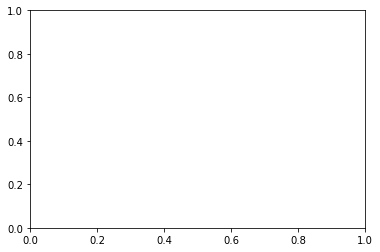

In [11]:
w = np.arange(1, 10+1, 1)
#plt.plot(w, ba_loss)
plt.plot(w, NN_loss)

In [ ]:
save = True
save_path = "../data/california_01/"
if save == True:
    np.save(save_path+"NN_loss.npy", np.array(NN_loss))
    np.save(save_path+"NN_test_loss.npy", np.array(NN_test_loss))
    np.save(save_path+"ba_loss.npy", np.array(ba_loss))
    np.save(save_path+"ba_test_loss.npy", np.array(ba_test_loss))

In [ ]:
plt.plot(w, ba_test_loss)
plt.plot(w, NN_test_loss)
plt.ylim(0, 100)

In [12]:
NN_loss

[137.81904895038474, 163.27359575625582, 142.05304475094496, 129.0722253425276]